In [11]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [12]:
HERE = Path.cwd()
DATA = HERE / "data"

DataFrame contains molecules from Zinc with molecular weight less than 200 and logP value of 2 (~500.000 molecules).

In [13]:
zinc_data = pd.read_csv("all_zinc_compounds_200_2.txt", sep="\t", names=["smiles", "zinc_id"])

print(zinc_data.head())

C:\Users\hrach\AppData\Local\Temp\ipykernel_14116\2843790533.py:1: DtypeWarning: Columns (1,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  zinc_data = pd.read_csv("all_zinc_compounds_200_2.txt", sep="\t", names=["smiles", "zinc_id"])


                                                                                                              smiles  \
smiles                          zinc_id inchikey                    mwt     logp  reactive purchasable  tranche_name   
Cc1cc(C(=O)O)nn1C(C)(C)C        128082  FCFGJNOOQYQMKY-UHFFFAOYSA-N 182.223 1.645 0        50                   ADAA   
Cc1cc(C=O)oc1C                  153224  JPTPEPVCVXGNJM-UHFFFAOYSA-N 124.139 1.709 0        50                   ADAA   
Oc1nc2ccc(Cl)cc2nc1O            336490  RNOLFZACEWWIHP-UHFFFAOYSA-N 196.593 1.694 0        50                   ADAA   
CC(C)[C@@H]1C(=O)C[C@@H](C)CN1C 1296142 ALCOISCHVBFFNS-PSASIEDQSA-N 169.268 1.552 0        50                   ADAA   

                                                                                                         zinc_id  
smiles                          zinc_id inchikey                    mwt     logp  reactive purchasable  features  
Cc1cc(C(=O)O)nn1C(C)(C)C        128082  FCFGJNOOQ

The data types are inconsistent so lets keep the first 6 columns and drop the rest.

In [15]:
zinc_data = pd.read_csv(
    "all_zinc_compounds_200_2.txt",
    sep="\t",
    names=["smiles", "zinc_id", "inchikey", "mwt", "logp", "reactive"],
    usecols=[0,1,2,3,4,5],
    low_memory=False
)

# Remove all rows that match the header pattern
zinc_data = zinc_data[~(zinc_data["smiles"] == "smiles")]
print("Dataframe shape", zinc_data.shape)
print(zinc_data.head())

Dataframe shape (486318, 6)
                            smiles  zinc_id                     inchikey  \
1         Cc1cc(C(=O)O)nn1C(C)(C)C   128082  FCFGJNOOQYQMKY-UHFFFAOYSA-N   
2                   Cc1cc(C=O)oc1C   153224  JPTPEPVCVXGNJM-UHFFFAOYSA-N   
3             Oc1nc2ccc(Cl)cc2nc1O   336490  RNOLFZACEWWIHP-UHFFFAOYSA-N   
4  CC(C)[C@@H]1C(=O)C[C@@H](C)CN1C  1296142  ALCOISCHVBFFNS-PSASIEDQSA-N   
5             COc1cc(N(C)C)ccc1C=O  1583074  HGDRXADJVGVGBC-UHFFFAOYSA-N   

       mwt   logp reactive  
1  182.223  1.645        0  
2  124.139  1.709        0  
3  196.593  1.694        0  
4  169.268  1.552        0  
5  179.219  1.574        0  


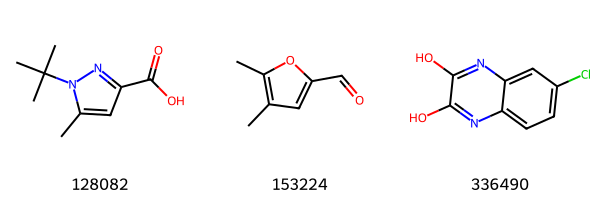

In [16]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(zinc_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(zinc_data.head(3).ROMol),
    legends=list(zinc_data.head(3).zinc_id),
)

Filter for PAINS

In [17]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [19]:
# search for Pains
matches = []
clean = []
for index, row in tqdm(zinc_data.iterrows(), total=zinc_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "zinc_id": row.zinc_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
zinc_data = zinc_data.loc[clean]    # keep molecules without PAINS

100%|██████████| 486318/486318 [13:18<00:00, 609.10it/s] 


In [21]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(zinc_data)}")

Number of compounds with PAINS: 3570
Number of compounds without PAINS: 482748


The first 3 identified PAINS are:

In [24]:
# Chem.Draw.MolsToGridImage(
#     list(zinc_data.head(3).ROMol),
#     legends=list(zinc_data.head(3)),
# )
zinc_data.head(3)

,smiles,zinc_id,inchikey,mwt,logp,reactive,ROMol
1,Cc1cc(C(=O)O)nn1C(C)(C)C,128082,FCFGJNOOQYQMKY-UHFFFAOYSA-N,182.223,1.645,0,<rdkit.Chem.rdchem.Mol object at 0x000001F0173...
2,Cc1cc(C=O)oc1C,153224,JPTPEPVCVXGNJM-UHFFFAOYSA-N,124.139,1.709,0,<rdkit.Chem.rdchem.Mol object at 0x000001F0173...
3,Oc1nc2ccc(Cl)cc2nc1O,336490,RNOLFZACEWWIHP-UHFFFAOYSA-N,196.593,1.694,0,<rdkit.Chem.rdchem.Mol object at 0x000001F0173...


**Filter and highlight unwanted substructures**

Some lists of unwanted substructures, like PAINS, are already implemented in RDKit. However, it is also possible to use an external list and get the substructure matches manually. Here, we use the list provided in the supporting information from Brenk et al. (Chem. Med. Chem. (2008), 3, 535-44).

Define Metal Elements

In [25]:
metal_elements = {
    "Li", "Na", "K", "Rb", "Cs", "Fr",
    "Be", "Mg", "Ca", "Sr", "Ba", "Ra",
    "Sc", "Y", "Ti", "Zr", "Hf", "V", "Nb", "Ta",
    "Cr", "Mo", "W", "Mn", "Tc", "Re",
    "Fe", "Ru", "Os", "Co", "Rh", "Ir",
    "Ni", "Pd", "Pt", "Cu", "Ag", "Au",
    "Zn", "Cd", "Hg", "Al", "Ga", "In", "Tl",
    "Sn", "Pb", "Bi"
}

Implement filter function for metals

In [26]:
def contains_metal(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return True
    for atom in mol.GetAtoms():
        if atom.GetSymbol() in metal_elements:
            return True
    return False

Apply to our dataframe

In [27]:
zinc_data["has_metal"] = zinc_data["smiles"].apply(contains_metal)
df_clean = zinc_data[~zinc_data["has_metal"]].drop(columns=["has_metal"])

print(f"Original count: {len(zinc_data)}")
print(f"Filtered count (no metals): {len(df_clean)}")

Original count: 482748
Filtered count (no metals): 482738
